In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
df = pd.read_csv('forestfires.csv')

# Indici del Fire Weather Index (FWI)

Il sistema **FWI (Fire Weather Index)** stima il rischio di incendi boschivi sulla base delle condizioni meteorologiche.
Gli indici descritti sotto rappresentano diversi aspetti della combustione e della propagazione del fuoco.

---

## FFMC – Fine Fuel Moisture Code

**Descrizione**  
Misura il contenuto di umidità dei combustibili fini superficiali  
(foglie secche, aghi di pino, erba, piccoli rami).

**Intervallo tipico:** 18 – 96+

**Soglie indicative**
- **< 75** → combustibile umido, bassa probabilità di innesco
- **75 – 85** → rischio moderato
- **85 – 90** → rischio alto
- **> 90** → combustibile estremamente secco, innesco molto facile

**Nota:** risponde rapidamente a pioggia, vento, temperatura e umidità.

---

## DMC – Duff Moisture Code

**Descrizione**  
Misura l’umidità dello strato di lettiera e materiale organico poco compatto
(sub-superficiale).

**Intervallo tipico:** 1 – 300+

**Soglie indicative**
- **< 30** → suolo umido
- **30 – 60** → condizioni normali
- **60 – 100** → secchezza elevata
- **> 100** → condizioni molto secche, incendio persistente

**Nota:** riflette effetti cumulativi su scala di giorni o settimane.

---

## DC – Drought Code

**Descrizione**  
Indica la secchezza degli strati profondi del suolo e dei combustibili grossi.

**Intervallo tipico:** 0 – 800+

**Soglie indicative**
- **< 100** → terreno umido
- **100 – 300** → secchezza moderata
- **300 – 500** → siccità marcata
- **> 500** → siccità estrema, incendi difficili da spegnere

**Nota:** varia lentamente ed è legato alla gravità degli incendi.

---

## ISI – Initial Spread Index

**Descrizione**  
Stima la velocità di propagazione iniziale di un incendio.

**Dipende da:** FFMC e velocità del vento.

**Intervallo tipico:** 0 – 50+

**Soglie indicative**
- **< 5** → propagazione lenta
- **5 – 10** → propagazione moderata
- **10 – 20** → propagazione rapida
- **> 20** → propagazione estremamente rapida


temp - temperature in Celsius degrees: 2.2 to 33.30
RH - relative humidity in %: 15.0 to 100
wind - wind speed in km/h: 0.40 to 9.40
rain - outside rain in mm/m2 : 0.0 to 6.4
area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform

# **Obiettivo**
Capire quali variabili meteo/FWI sono associate a incendi più estesi e quando/dove il rischio è maggiore.

Domande guida:

- In quali mesi si osservano condizioni FWI più critiche?

- La superficie bruciata (area) è più legata a vento/umidità o agli indici FWI?

- Esistono “zone” con più eventi?

**PREPARAZIONE DEL DATASET**


*Gestione duplicati*

In [81]:
duplicati = df[df.duplicated(keep = False)]
if  duplicati.empty:
    print(f'Non ci sono duplicati nel dataset')   
else:   
    print(f'Sono presenti {len(duplicati)} duplicati nel dataset')
duplicati

Sono presenti 8 duplicati nel dataset


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
52,4,3,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00
53,4,3,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00
99,3,4,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00
100,3,4,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00
214,4,4,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66
215,4,4,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66
302,3,6,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00
303,3,6,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00


In [82]:
df = df.drop_duplicates()
duplicati = df[df.duplicated(keep= False)]
if  duplicati.empty:
    print(f'Non ci sono duplicati nel dataset')   
else:   
    print(f'Sono presenti {len(duplicati)} duplicati nel dataset')

Non ci sono duplicati nel dataset


*valori nulli*

In [83]:
df.info()

<class 'pandas.DataFrame'>
Index: 513 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       513 non-null    int64  
 1   Y       513 non-null    int64  
 2   month   513 non-null    str    
 3   day     513 non-null    str    
 4   FFMC    513 non-null    float64
 5   DMC     513 non-null    float64
 6   DC      513 non-null    float64
 7   ISI     513 non-null    float64
 8   temp    513 non-null    float64
 9   RH      513 non-null    int64  
 10  wind    513 non-null    float64
 11  rain    513 non-null    float64
 12  area    513 non-null    float64
dtypes: float64(8), int64(3), str(2)
memory usage: 56.1 KB


Non sono presenti valori nulli nel dataset.

In [84]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,4.678363,4.300195,90.637427,110.989279,549.155166,9.023587,18.887524,44.348928,4.010526,0.021832,12.891598
std,2.320059,1.230925,5.540920,64.191013,247.724594,4.575543,5.828128,16.358803,1.796613,0.297107,63.892586
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,440.900000,6.400000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.540000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,11.000000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [85]:
df['RH'] = df['RH'].astype(float)

In [86]:
#possibili outliers
mean = df['area'].mean()
std = df['area'].std()

df['Z-score'] = (df['area'] - mean) / std

outliers = df[abs(df['Z-score']) > 3]
print("Outlier identificati con Z-score > 3 o < -3:")
print(outliers[['area', 'Z-score']])


Outlier identificati con Z-score > 3 o < -3:
        area    Z-score
237   212.88   3.130072
238  1090.84  16.871260
415   746.28  11.478459
479   278.53   4.157578


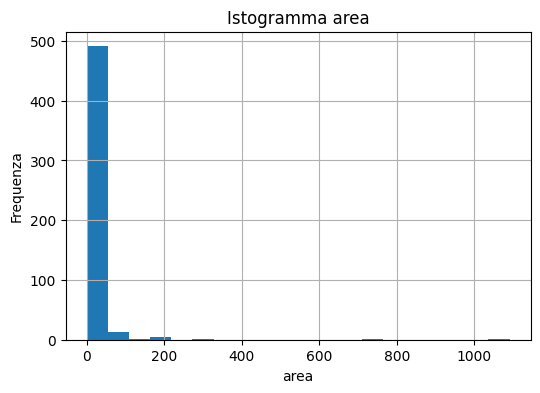

In [87]:
df['area'].hist(bins=20, figsize=(6,4))
plt.xlabel('area')
plt.ylabel('Frequenza')
plt.title('Istogramma area')
plt.show()

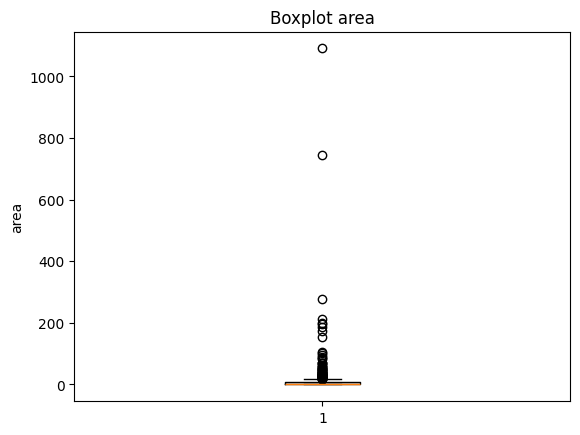

In [88]:
plt.boxplot(df['area'], vert=True)
plt.title('Boxplot area')
plt.ylabel('area')
plt.show()

In [89]:
df['area_ln'] = np.log10(1+df['area'])
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Z-score,area_ln
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,4.678363,4.300195,90.637427,110.989279,549.155166,9.023587,18.887524,44.348928,4.010526,0.021832,12.891598,0.000000,0.483405
std,2.320059,1.230925,5.540920,64.191013,247.724594,4.575543,5.828128,16.358803,1.796613,0.297107,63.892586,1.000000,0.607007
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,-0.201770,0.000000
25%,3.000000,4.000000,90.200000,68.600000,440.900000,6.400000,15.500000,33.000000,2.700000,0.000000,0.000000,-0.201770,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.540000,-0.193318,0.187521
75%,7.000000,5.000000,92.900000,142.400000,713.900000,11.000000,22.800000,53.000000,4.900000,0.000000,6.570000,-0.098941,0.879096
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,16.871260,3.038159


In [90]:
# Non ci servono più le ultime colonne
del df['area']
del df['Z-score']


In [91]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area_ln
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,4.678363,4.300195,90.637427,110.989279,549.155166,9.023587,18.887524,44.348928,4.010526,0.021832,0.483405
std,2.320059,1.230925,5.540920,64.191013,247.724594,4.575543,5.828128,16.358803,1.796613,0.297107,0.607007
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,440.900000,6.400000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.187521
75%,7.000000,5.000000,92.900000,142.400000,713.900000,11.000000,22.800000,53.000000,4.900000,0.000000,0.879096
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,3.038159


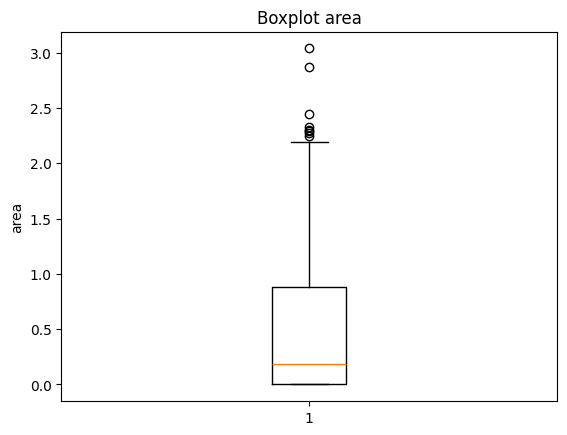

In [92]:
plt.boxplot(df['area_ln'], vert=True)
plt.title('Boxplot area')
plt.ylabel('area')
plt.show()

L'area è fortemente asimmetrica e con molti zeri, motivo per cui abbiamo scelto di fare la trasformazione a logaritmo.

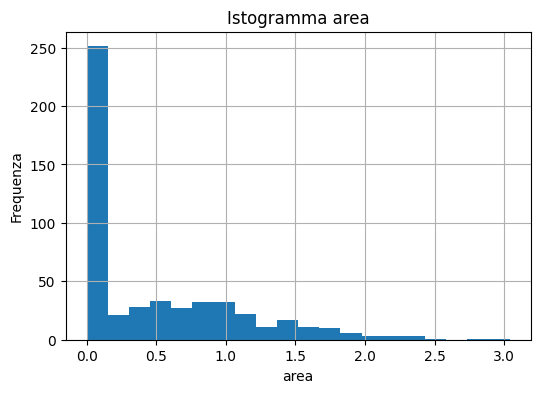

In [93]:
df['area_ln'].hist(bins=20, figsize=(6,4))
plt.xlabel('area')
plt.ylabel('Frequenza')
plt.title('Istogramma area')
plt.show()

Vediamo come sono correlate le diverse variabili considerate:

<Axes: >

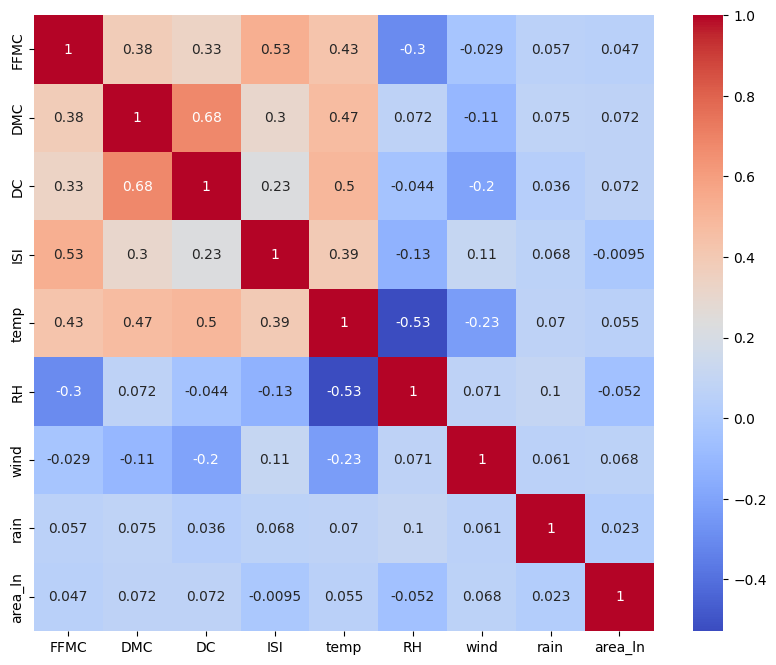

In [94]:

df_numeric = df.select_dtypes(include=[float])
corr = df_numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')


Come visibile, i vari indici di rischio aumentano con la Temperatura.

Si noti come l'ISI ha una correlazione leggermente relativa con la pioggia, nonostante verrebbe da immaginare il contrario: questo dipende dal fatto che sono pochissimi i casi in cui abbia piovuto durante un incendio (8 su 513).

In [95]:
df1 = df.groupby('month')[['area_ln']].sum()
df1

,area_ln
month,
apr,4.257394
aug,83.521814
dec,10.051759
feb,9.448804
jan,0.000000
jul,15.059812
jun,6.224544
mar,16.645937
may,1.596377


Si vede bene come gli incendi propagano su aree maggiori durante i mesi estivi, in particolare Agosto e Settembre.

In [96]:
df1 = df.groupby('month')[['FFMC','DMC','DC','ISI']].mean()
df1

,FFMC,DMC,DC,ISI
month,,,,
apr,85.788889,15.911111,48.555556,5.377778
aug,92.343407,154.028571,641.224176,11.082967
dec,84.966667,26.122222,351.244444,3.466667
feb,82.905000,9.475000,54.670000,3.350000
jan,50.400000,2.400000,90.350000,1.450000
jul,91.328125,110.387500,450.603125,9.393750
jun,89.325000,93.337500,301.806250,12.068750
mar,89.401887,34.518868,75.850943,7.094340
may,87.350000,26.700000,93.750000,4.600000


Ad Agosto e Settembre, infatti, sono più elevati anche i valori degli indici di rischio.

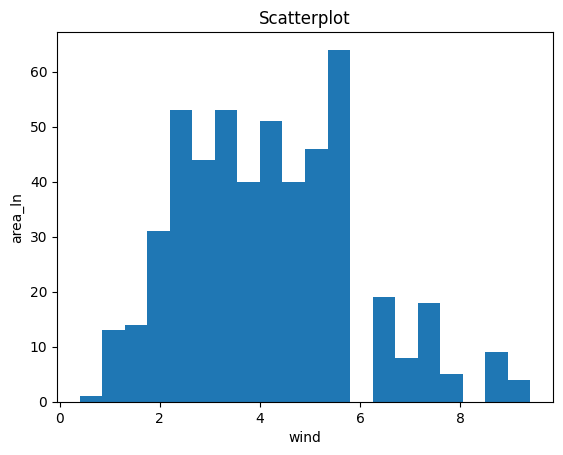

In [97]:
plt.hist(
    df['wind'], bins = 20
)
plt.title('Scatterplot')
plt.xlabel('wind')
plt.ylabel('area_ln')
plt.show()


L'area bruciata aumenta con il vento ma solo fino a una certa intensità, oltre la quale l'incendio si affievolisce.

In [98]:

heatmap, xedges, yedges = np.histogram2d(
    df['X'],
    df['Y'],
    bins = 8,
    range = [[1,9],[1,9]]
)

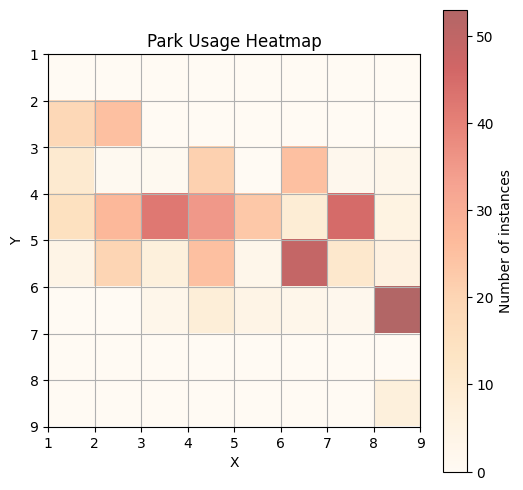

In [99]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(figsize = (6,6))

'''
ax.imshow(
    img,
    extent = [1,9,1,9],
    origin = 'lower',
    cmap = 'hot',
    alpha = 0.6
)
'''

im = ax.imshow(
    heatmap.T,
    extent = [1,9,9,1],
    origin = 'upper',
    cmap = 'OrRd',
    alpha = 0.6
)

plt.colorbar(im, ax = ax, label = 'Number of instances')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Park Usage Heatmap')
ax.grid()


Il grafico mostra una griglia spaziale del parco, con i valori del numero di incendi avvenuti in ogni "zona".